# **Шаг 1 загрузка данных**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.metrics import r2_score as r2

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression as LR




DATASET_TRAIN_PATH = "./input/train.csv"
DATASET_TEST_PATH = "./input/test.csv"
PREPARED_TRAIN_DATASET_PATH = "./output/train_prepared.csv"
PREPARED_TEST_DATASET_PATH = "./output/test_prepared.csv"
OUTPUT_PATH = "./output/test_predicted.csv"
MODEL_PATH = "./output/model.pickle"

RANDOM_VAL = 228

In [2]:
df = pd.DataFrame(pd.read_csv(DATASET_TRAIN_PATH))
df.index = df["Id"]
df = df.drop("Id", axis = 1)
dataset = df.copy() # toy dataset

In [3]:
def reduce_mem_usage_rv(df):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of raw dataframe: {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                types = [np.int8, np.int16, np.int32, np.int64]
                for type_n in types:
                    if c_min > np.iinfo(type_n).min and c_max < np.iinfo(type_n).max:
                        df[col] = df[col].astype(type_n)
                        break
            elif str(col_type)[:4] == "float":
                types = [np.float8, np.float16, np.float32, np.float64]
                for type_n in types:
                    if c_min > np.iinfo(type_n).min and c_max < np.iinfo(type_n).max:
                        df[col] = df[col].astype(type_n)
                        break
        else:
            df[col] = df[col].astype('category')
            
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print("Memory usage after optimization: {:.2f} MB".format(end_mem))
    
    return df

def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    plt.scatter(x=train_pred_values, y=train_true_values)
    #sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    plt.scatter(x=test_pred_values, y=test_true_values)
    #sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [4]:
dataset = reduce_mem_usage_rv(dataset)
dataset.head()

Memory usage of raw dataframe: 1.53 MB
Memory usage after optimization: 0.85 MB


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


# **Шаг 2 анализ и очистка данных**

## Анализ распределения цены

Проведем анализ распределения цены:

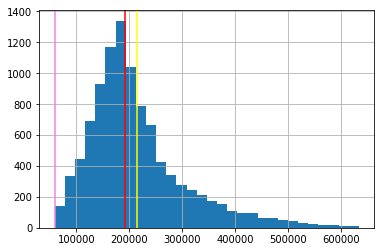

In [5]:
from scipy.stats import mode

median = np.median(dataset['Price'])
average = np.average(dataset['Price'])
mode_v = mode(dataset['Price'])

dataset['Price'].hist(bins = 30)
plt.axvline(median, c = 'red')
plt.axvline(average, c = 'yellow')
plt.axvline(mode_v.mode, c = 'violet')
plt.show()

По общему анализу распределения цены, не видно очевидных выбросов - наиболее популярная цена находится рядом с мединным значением так же как и со средним значением. Есть небольшая доля квартир стоимостью более USD 400000, но, с виду, они не превышают 5%. Количетсво значений, равных моде (фиолетовая линия) равно 1 единице, что ожидаемо от дескретных величин.

Рассмотрим проведем аналогичную процедуру с объединенными данными в коризины: 

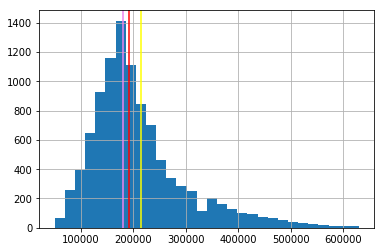

180000.0    740
170000.0    673
160000.0    614
190000.0    596
150000.0    543
200000.0    517
140000.0    495
210000.0    469
130000.0    435
220000.0    373
Name: Price, dtype: int64


In [6]:
price_bins = dataset['Price'] // 10000 * 10000
mode_v_cat = mode(price_bins)

price_bins.hist(bins = 30)
plt.axvline(median, c = 'red')
plt.axvline(average, c = 'yellow')
plt.axvline(mode_v_cat.mode, c = 'violet')
plt.show()
print(price_bins.value_counts().iloc[:10])

Теперь мода близка к среднему значению и медиане, что не говорит о наличии очевидных выбросов

## Анализ призаков

### Анализ количественных признаков

Рассмотрим признаки с количественными типами данных и выявим из них действительно количественные признаки:

In [7]:
numeric_features = dataset.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
numeric_features = numeric_features.drop(['Price'], axis = 1)
numeric_features.head()


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
Id,,,,,,,,,,,,,,,
11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0,0
3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0
8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1
2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1
13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,0,6


Признак DistrictId явно нам не подойдут для анализа. Так же было бы неплохо понимать, что такое социальные, экологические и медицинские показатели, однако их описание отсутствует.

Проанализируем распределение количественных признаков:

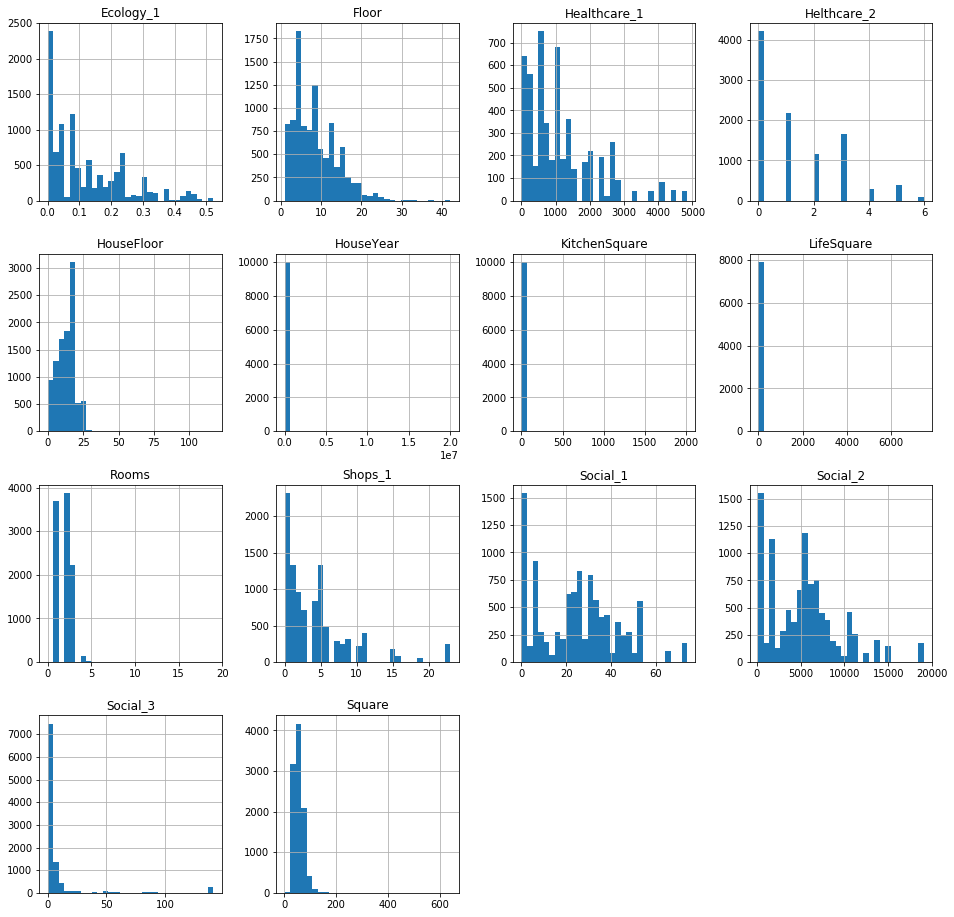

In [8]:
numeric_features = numeric_features.drop(['DistrictId'], axis = 1)

numeric_features.hist(figsize = (16,16), bins = 30)
plt.show()

Показатель Ecology_1 достаточно сильно концентрируется у около нулвого значения. Вероятно, это логично ввиду низкой экологичности Москвы как очень крупного города. Рассмотрим этот показатель внимательнее:

In [9]:
dataset["Ecology_1"].value_counts().head()

0.007122    587
0.000000    537
0.243205    511
0.072158    486
0.075779    346
Name: Ecology_1, dtype: int64

Показатель этажа квартиры концентрируется у значений 4-6 тажа т 8-9 этажа. Рассмотрим показатель ближе:

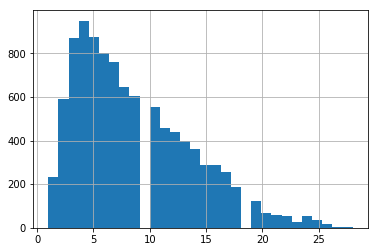

In [10]:
dataset["Floor"][dataset["Floor"] < 30].hist(bins = 30)

Начиная с 3-4 этажа распределение соответствует ожиданиям, однако 2 этажей выборке немного меньше ожиадемого - в каждом 5 этажном доме должен быть 2 этаж. Это говорит о немного нерепрезнативной выборке. Однако, это не должно существенно повлиять на выборку. Так же мы наблюдаем наличие квартир на 1-м этаже, на котором зачастую располагаются служебные помещения. Соответственно, их малое количество ожидаемо.

Рассмотрим показатели Здравохранения:

540.0     511
30.0      348
1046.0    245
750.0     163
229.0     148
Name: Healthcare_1, dtype: int64

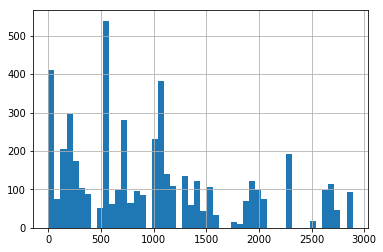

In [11]:
dataset["Healthcare_1"][dataset["Healthcare_1"] < 3000].hist(bins = 50)
dataset["Healthcare_1"].value_counts().head()

In [12]:
dataset["Helthcare_2"].value_counts()

0    4214
1    2183
3    1670
2    1158
5     388
4     288
6      99
Name: Helthcare_2, dtype: int64

С виду очень трудно понять что это за показатели. Рассмотрим корреляцию между ними:

In [13]:
print(dataset.corr()["Healthcare_1"]["Helthcare_2"])
print(dataset.corr()["Healthcare_1"]["Price"])
print(dataset.corr()["Helthcare_2"]["Price"])

0.203177421479234
0.13875459339373034
0.25309001117772173


Признаки, которые должны представлять схожие вещи имеют минимальную корреляцию. Так же отсутствует корреляция с ценой дома. Стоит рассмореть вариант исключения данных признаков в будущем ввиду отсутствия понимания данных величин и отсутствия корреляции как между собой, так и с ценой недвижимости.

Рассмотрим данные по количетсву этажей в доме:

17.0    2331
9.0     1389
12.0    1074
5.0     1031
14.0     625
Name: HouseFloor, dtype: int64

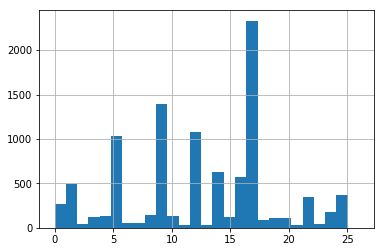

In [14]:
dataset["HouseFloor"][dataset["HouseFloor"] < 27].hist(bins = 27)
dataset["HouseFloor"].value_counts().head()

Обилие квартир в 17-этажных домах является возможным ввиду широкого распространения домов серии ПЗМ-1/14 и П-44 в Москве. Возведение 9-ти, 12-ти и 5-ти этажных домов так же было очень распротсранено в 60-80-е годы. Стоит отметить наличие 1-2 этажных домов, что может означать частные дома.

Рассмотрим год возведения дома:

1977    2652
2017     308
2016     305
2015     299
2014     210
Name: HouseYear, dtype: int64

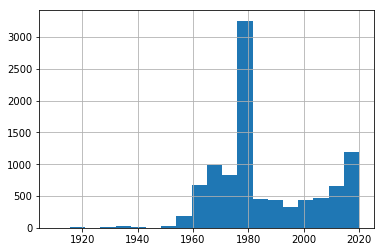

In [15]:
dataset["HouseYear"][dataset["HouseYear"] < 2021].hist(bins = 20)
dataset["HouseYear"].value_counts().head()

In [16]:
print(dataset[:][dataset["HouseYear"] == 1977].describe()[["Square", "Price"]])
print(dataset.describe()[["Square", "Price"]])
print(dataset["HouseYear"][dataset["HouseYear"] > 2020])

            Square          Price
count  2652.000000    2652.000000
mean     59.706815  180270.526772
std      22.235055   72493.367538
min       1.136859   60502.583500
25%      43.559084  131533.902089
50%      58.313306  168658.344363
75%      67.981898  208072.197053
max     604.705972  627525.072788
             Square          Price
count  10000.000000   10000.000000
mean      56.315775  214138.857399
std       21.058732   92872.293865
min        1.136859   59174.778028
25%       41.774881  153872.633942
50%       52.513310  192269.644879
75%       65.900625  249135.462171
max      641.065193  633233.466570
Id
11607        4968
10814    20052011
Name: HouseYear, dtype: int32


Более 26% выборки составляют дома, построенные в 1977 году, что говорит о нерепрезнтативности выборки. Действительно, в 70-е было очень активное строительство жилья (даже превышающее современные темпы), но 1977 год не является особенным в истории строительства жилых домов. Есть вероятность наличия множества однотипных данных. Стоит рассмотреть возможность сокращения или сжатия входны объектов, имеющие год постройки в 1977 году, если объем данных позволит это сделать. Однако, площадь квартир в таких дома сильно варьируется и при этом близко значению отклонения всей выборки, что говорит о репрезентативности.
Помимо этого, среди данных обнаружены значения 20052018 и 4968, что явно является ошибкой ввода.

Рассмотрим данные по площади квартир:

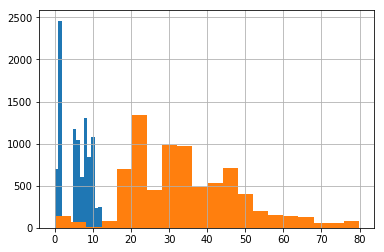

In [17]:
dataset["KitchenSquare"][dataset["KitchenSquare"] < 20].hist(bins = 20)
dataset["LifeSquare"][dataset["LifeSquare"] < 80].hist(bins = 20)

count    7866.000000
mean        6.926646
std         3.696507
min         0.000000
25%         5.000000
50%         7.000000
75%         9.000000
max        48.000000
Name: KitchenSquare, dtype: float64

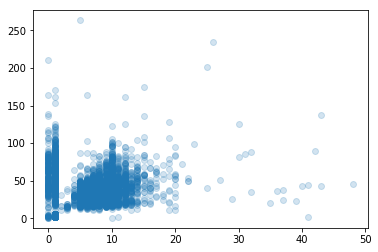

In [18]:
plt.scatter(
    dataset["KitchenSquare"][(dataset["KitchenSquare"] < 50) & 
                             (dataset["LifeSquare"] < 400)], 
    dataset["LifeSquare"][(dataset["KitchenSquare"] < 50) & 
                          (dataset["LifeSquare"] < 400)], 
    alpha = 0.2)
dataset["KitchenSquare"][(dataset["KitchenSquare"] < 50) & (dataset["LifeSquare"] < 700)].describe()


По анализу можно сделать вывод, что более 21% выборки имеют площадь кухни более 50 м2 или жилую площадь более 700 м2. Скорее всего речь идет о частных домах или квартир с большим количеством комнат. Ценооборазование таких домов может существенно отличатся от остальных 79% выборки. В дальнейшем анализе стоит рассмотреть возможность отдельных предсказаний такой группы (хотя данных и без того очень мало). Так же стоит рассмотреть возможность выделить частные и роскошные дома в отдельный дополнительный признак. 
Отсутствие кухни в некоторых квартирах ожидаемо - В москве есть много квартир - студий. Однако, минимум жилой площади стоит рассмотреть более детально:

count    203.000000
mean       3.465692
std        1.531754
min        0.370619
25%        2.074949
50%        3.512299
75%        4.761866
max        5.996579
Name: LifeSquare, dtype: float64
count       203.000000
mean     198928.267403
std       98900.687318
min       64530.702769
25%      133636.746913
50%      178486.385759
75%      220027.346033
max      611250.912034
Name: Price, dtype: float64


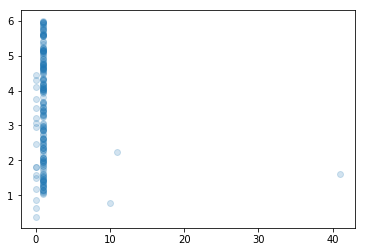

In [19]:
plt.scatter(
    dataset["KitchenSquare"][(dataset["KitchenSquare"] < 50) & 
                             (dataset["LifeSquare"] < 8)], 
    dataset["LifeSquare"][(dataset["KitchenSquare"] < 50) & 
                          (dataset["LifeSquare"] < 8)], 
    alpha = 0.2)
print(dataset["LifeSquare"][(dataset["KitchenSquare"] < 50) & (dataset["LifeSquare"] < 8)].describe())
print(dataset["Price"][(dataset["KitchenSquare"] < 50) & (dataset["LifeSquare"] < 8)].describe())

203 квартиры имеют площадь менее 8 м2 и при этом их средняя стоимость близка к средней стоимости квартир всей выборки. Данные квартиры вероятно являются выбросами и никак не отражают ценообразования для остальной выборки. В дальнейшем стоит исключить данные объекты из выборки.

Сделаем далее анализ соотношения площади кухни к жилой площади. Мы не ожидаем превышаения площади кухни к жилой площади.

In [20]:
dataset["KitchenLifeSqareRatio"] = dataset["KitchenSquare"]/dataset["LifeSquare"]
dataset["KitchenLifeSqareRatio"][dataset["KitchenLifeSqareRatio"] > 0.7].describe()

count     75.000000
mean       3.823699
std       13.117288
min        0.705639
25%        0.791597
50%        0.934841
75%        1.161495
max      102.186934
Name: KitchenLifeSqareRatio, dtype: float64

75 квартиры имеют соотношение площади кухни к жилой площади более 70%, а максимум доходит до 102. Эти объекты, вероятно, не являются репрезентативными и стоит очистить данные объекты от выборки.

Рассмотрим данные по количетсву комнат:

count    8.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: Rooms, dtype: float64
count    22.000000
mean      6.136364
std       3.226312
min       5.000000
25%       5.000000
50%       5.000000
75%       5.000000
max      19.000000
Name: Rooms, dtype: float64


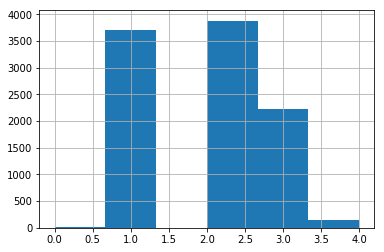

In [21]:
dataset["Rooms"][dataset["Rooms"] < 5].hist(bins = 6)
print(dataset["Rooms"][dataset["Rooms"] == 0].describe())
print(dataset["Rooms"][dataset["Rooms"] > 4].describe())

30 квартир либо не имеют комнат, либо имеют более 4-х комнат, что не является репрезентативной выборкой. Стоит очистить от них данные позже.

Рассмотрим корреляциюмежду социальными показателями:

In [22]:
dataset.corr()[["Social_1", "Social_2", "Social_3"]]

,Social_1,Social_2,Social_3
DistrictId,0.246463,0.167479,0.136095
Rooms,0.075980,0.071335,0.012811
Square,-0.070690,-0.043120,0.035241
LifeSquare,-0.048363,-0.039283,0.012763
KitchenSquare,0.043379,0.037805,-0.015140
Floor,-0.044914,-0.016560,-0.002237
HouseFloor,-0.020801,0.007194,-0.008137
HouseYear,0.003026,0.001970,0.000819
Ecology_1,0.026464,0.009264,-0.124068
Social_1,1.000000,0.955988,0.023721


Без подробного описания очень трудно понять смысл и значение данных переменных. Однако, первые два признака коррелируют между собой, что говорит о том, что они по-разному описывают одно направление. 3-й признак не коллерирует с двумя остальными, но имеет связь с показателем доступных магазинов. Без понимания сути показателей трудно судить, что тут может являтся выбросами. Нормально ли значение 0 во многих случаях?

Рассмотрим значение общей площади. Ожидается, что площадь должна коррелировать с суммой площади кухни и жилой площади и, как минимум, не быть меньше этой суммы.

In [23]:
dataset["TotalLiveSquare"] = dataset["KitchenSquare"] + dataset["LifeSquare"]
print(dataset.corr()["Square"])
dataset["LiveSquareDiff"] = dataset["Square"] - dataset["TotalLiveSquare"]
print(dataset["LiveSquareDiff"][dataset["LiveSquareDiff"] < 0].describe())
dataset[dataset["LiveSquareDiff"] < 0].info()

DistrictId              -0.026613
Rooms                    0.662893
Square                   1.000000
LifeSquare               0.196129
KitchenSquare            0.008320
Floor                    0.114791
HouseFloor               0.081505
HouseYear               -0.009032
Ecology_1               -0.064479
Social_1                -0.070690
Social_2                -0.043120
Social_3                 0.035241
Healthcare_1            -0.039748
Helthcare_2             -0.022960
Shops_1                  0.021357
Price                    0.520075
KitchenLifeSqareRatio   -0.043781
TotalLiveSquare          0.190853
Name: Square, dtype: float64
count     845.000000
mean      -20.797568
std       272.428012
min     -7399.897712
25%        -8.462495
50%        -3.486897
75%        -1.350590
max        -0.006128
Name: LiveSquareDiff, dtype: float64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 845 entries, 847 to 9289
Data columns (total 22 columns):
DistrictId               845 non-null int16
Ro

845 квартир имеют общую площадь меньше, чем сумма площадей кухни и жилой площади. Более того, значение площади не коррелирует с площадью кухни или жилой площадью. Сильная корреляция не ожидается ввиду того, что в общую площадь включается балкон, санузлы и прочие части квартиры, которые могут существенно варьироватся. Однако, корреляция в менее,чем в 0.2 оставлют подозрения в наличии высокого шума при сборе данных. При анализе обучении лучше оставить одну из групп признаков - или общую площадь, или площади кухни и жилых помещений. Важно отметить, что корреляция Общей площади с ценой заметно выше, чем аналогичная корреляция жилой и кохонной площади. Вероятно, оптимальной стратегией будет оставить из трех признаков оставить только общую площадь в и добавить соотношение площади кухни к жилой площади.
По показателю площади так же наблюдается чрезмерно низкие и высокие показатели. Их количество невелико и подлежит корректировке в рамках 4% самых высоких и низких величин.

**Итого по результатам анализа количетсвенных показателей:**

1) Показатели здравохранения являются сомнительными и подлежат к исключению

2) 26% выборки концентрируются в домах, построенные в 1977 году, что потенциально является нерепрезнтативной выборкой. При построении модели стоит рассмотреть возможность сжатия таких объектов

3) В выборке присутствуют дома, построеные в 4968 и 20052011 годах. Стоит заменить данные значения на средние по выборке.

4) В выборке присутствуют квартиры с площадью кухни более 50 м2 и жилой площадью более 400 м2. Вероятно, это частные или многоквартирные дома, которые стоит поместить в отдельную категорию

5) Общая площадь не коррелирует с площадью кухни, жилой площадью, а так же их суммой. Вместо площади кухни и жилой площади стоит использовать их отношение между собой.

6) Добавлен новый признак: KitchenLifeSqareRatio

### Анализ качественных признаков

Рассмотрим признаки, которые не были рассмотрены ранее - DistrictId, Ecology_2, Ecology_3, Shops_2.

В выборке представлены номера районов до номера 209. По отрытым источникам удалось найти список районов до 144-го. Соотнести номера районов с картой москвы представляется затруднительным. Можно было бы разбить районы на 209 отдельных признаков, но врятли это сильно поможет. Еще есть варианты добавить признаки по средней стоимости домов в районе, среднего показателя по экологии, среднему наличию магазинов и плотности заселения.

,AvgDistrictPrice,AvgPopulation,AvgEcology,AvgShops
27,156046.416277,851,7.834251e-02,0.437133
22,190502.442094,78,1.104351e-01,1.115385
1,187805.401737,652,9.185492e-03,0.990798
94,204464.461105,89,3.050875e-01,5.258427
99,184157.448198,97,2.149871e-02,5.731959
44,229937.781749,104,1.091082e-01,1.951923
59,322216.314863,67,9.279218e-02,5.208955
6,166127.145161,511,2.432045e-01,0.000000
2,243688.618402,78,1.376130e-01,5.717949
88,226775.280656,64,1.273759e-01,9.000000


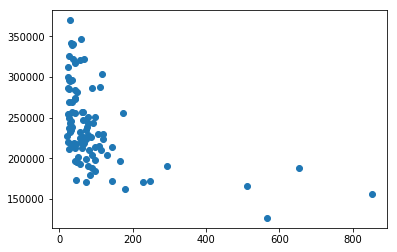

In [24]:
districtAvgs = [np.average(dataset["Price"][dataset["DistrictId"] == n]) for n in dataset["DistrictId"].unique()]
districtAvgs = pd.DataFrame(districtAvgs,index =  dataset["DistrictId"].unique())
districtAvgs.columns = ["AvgDistrictPrice"]
districtAvgs["AvgPopulation"] = [(dataset["Price"][dataset["DistrictId"] == n]).count() for n in dataset["DistrictId"].unique()]
districtAvgs["AvgEcology"] = [np.average(dataset["Ecology_1"][dataset["DistrictId"] == n]) for n in dataset["DistrictId"].unique()]
districtAvgs["AvgShops"] = [np.average(dataset["Shops_1"][dataset["DistrictId"] == n]) for n in dataset["DistrictId"].unique()]
plt.scatter(
    districtAvgs["AvgPopulation"][districtAvgs["AvgPopulation"] > 20], 
    districtAvgs["AvgDistrictPrice"][districtAvgs["AvgPopulation"] > 20])
districtAvgs

Средняя стоимость домов в районе не сильно коррелирует со средним количеством населения в них. Однако, эти признаки не являются лишними.

Рассмотрим показатели Экологии 2 и 3

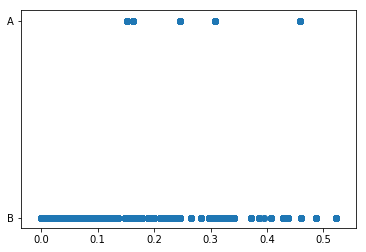

In [25]:
plt.scatter(dataset["Ecology_1"], dataset["Ecology_3"])

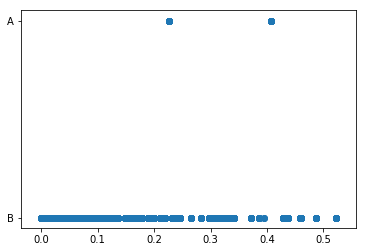

In [26]:
plt.scatter(dataset["Ecology_1"], dataset["Ecology_2"])

Можно отметить, что значение А принимается лишь при некоторых зачениях Ecology_1. Однако, прямой зависимости между признаками трудно установить. 

Рассмотрим признак Shops_2:

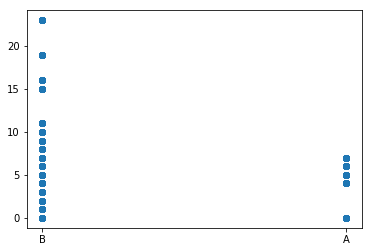

In [27]:
plt.scatter(dataset["Shops_2"], df["Shops_1"])

Очевидной зависимости так же не наблюдается.

**Итого по результатам анализа качественных показателей:**

1) Добавленны признаки средней стоимости жилья по районам, экологического показателя, показателя наличия магазинов, а так же населенность района

## Анализ по результатам первых предсказаний

После оценки первых предсказаний, выяснилось, что некоторая часть квартир с существенной площадью стоят заметно меньше ожидаемого

# Шаг 3: Очистка данных и Feature engineering

Рассмотрим отсутствующие данные:

Сконструируем класс обработки данных, сделанный на основе анализа в шаге 2

In [28]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        pass
        
    def fit(self, df, max_districts = 1000):
        self.categoric_features = ["DistrictId", "Ecology_2", "Ecology_3", "Shops_2"]
        self.numeric_features = [n for n in df.columns.tolist() if self.categoric_features.count(n) == 0]
        
        # saving key statistical variables
        self.avg = df[self.numeric_features].mean()
        self.median = df[self.numeric_features].median()
        self.mode = df.mode()
        
        # creating avg statistics on districts
        self.districts = np.empty(max_districts,dtype = np.int16) # expected max of possible districts
        for n in range(0, max_districts): 
            self.districts[n] = n
        self.districtAvgs = pd.DataFrame(index =  self.districts, 
                                         columns = ["AvgPrice", "AvgPopulation", "AvgEcology", "AvgShops", "AvgSqrPrice"])
        
        self.avg_sqr_price = np.sum(df["Price"]) / np.sum(df["Square"])
        
        for i, rows in self.districtAvgs.iterrows():
            if (np.sum(df["DistrictId"] == i) > 0):
                rows["AvgPrice"] = np.average(df["Price"][df["DistrictId"] == i])
                rows["AvgPopulation"] = np.sum(df["DistrictId"] == i)
                rows["AvgEcology"] = np.average(df["Ecology_1"][df["DistrictId"] == i])
                rows["AvgShops"] = np.average(df["Shops_1"][df["DistrictId"] == i])
                rows["AvgSqrPrice"] = np.average(df["Price"][df["DistrictId"] == i] / df["Square"][df["DistrictId"] == i])
            else:
                rows["AvgPrice"] = np.average(self.avg["Price"])
                rows["AvgPopulation"] = 1
                rows["AvgEcology"] = np.average(self.avg["Ecology_1"])
                rows["AvgShops"] = np.average(self.avg["Shops_1"])
                rows["AvgSqrPrice"] = self.avg_sqr_price      
        
        # fitting scaler on transformed data
        self.sc = StandardScaler()
        self.df_for_scale = self.transform(df, scaling = False, can_delete_rows = False, reduce_mem = False, final = False).drop(["Price"], axis = 1)
        self.sc.fit(self.df_for_scale)
        
        return self.categoric_features, self.numeric_features
        
    def transform(self, df, scaling = True, can_delete_rows = True, reduce_mem = True, final = True):
        
        # saving target values to insert to final df (in future better find more elegant way)
        if ( not final):
            self.indexes = df.index
            self.target = pd.DataFrame(df["Price"], index = self.indexes)

        # NaN fill
        for n in self.numeric_features:
            if (n != "Price"):
                df[n] = df[n].fillna(value = self.median[n])
        for n in self.categoric_features:
            df[n] = df[n].fillna(value = self.mode[n])

        # Healthcare_1 drop
        df = df.drop(["Healthcare_1"], axis = 1)
        
        # Change of house build date from future
        df = df.replace(df.loc[df["HouseYear"] > 2020, "HouseYear"],value = self.median["HouseYear"])

        # adding house / huge appartmetns criteria
        df["Huge"] = (df["LifeSquare"] > 50) | (df["Rooms"] > 50)
        
        # adding kitchen / living space ratio and deleting those exeeding 0.7
        df["KitchenLifeSqareRatio"] = df["KitchenSquare"] / df["LifeSquare"]
        if (can_delete_rows):
            df = df.drop(df[df["KitchenLifeSqareRatio"] > 0.7].index)

        # house age
        df["HouseAge_cat"] = (2021 - df["HouseYear"]) // 10
        
        # excluding apartments with less than 8 m2 square   
        if (can_delete_rows):
            df = df.drop(df[df["Square"] < 8].index)
        
        # transforming categorical features
        df["Ecology_2"] = df["Ecology_2"] == 'A'
        df["Ecology_3"] = df["Ecology_3"] == 'A'
        df["Shops_2"] = df["Shops_2"] == 'A'
        
        # dropping kitchen and living space features
        df = df.drop(["LifeSquare", "KitchenSquare"], axis = 1)
        
        # adding district features and deleting DistrictId
        df.merge(self.districtAvgs, left_on = 'DistrictId', right_on = self.districtAvgs.index, how = 'left', left_index = True)
        df = df.drop(["DistrictId"], axis = 1)
        
        # feature scaling
        if (scaling and not final):
            df = df.drop(["Price"], axis = 1)
            self.features_total = df.columns
            df = pd.DataFrame(self.sc.transform(df), index = df.index)
            df.columns = self.features_total
        elif (scaling):
            self.features_total = df.columns
            df = pd.DataFrame(self.sc.transform(df), index = df.index)
            df.columns = self.features_total

        
        # replacing scaled price with actual
        if (not final):
            df["Price"] = np.nan
            df["Price"].update(self.target["Price"])
                
        # optimizing size
        if (reduce_mem):
            df = reduce_mem_usage_rv(df)
        
        return df
    
    


In [29]:
"""
dp = DataPipeline()
dp.fit(dataset)
dataset_test = dp.transform(dataset)
dataset_test.head()
"""

'\ndp = DataPipeline()\ndp.fit(dataset)\ndataset_test = dp.transform(dataset)\ndataset_test.head()\n'

# Шаг 4. Разбиение на train / test

In [30]:
# split
df_train, df_test = train_test_split(df, test_size=0.2, shuffle = True, random_state = RANDOM_VAL)

# fitting DataPipeLine
dp = DataPipeline()
dp.fit(df_train, max_districts = 1000)

# transformation of train and validation set
df_train_prepared = dp.transform(df_train, final = False)
df_test_prepared = dp.transform(df_test, can_delete_rows = False, final = False)

# saving datasets
df_train_prepared.to_csv(PREPARED_TRAIN_DATASET_PATH)
df_test_prepared.to_csv(PREPARED_TEST_DATASET_PATH)

# 
X_train_prepared = df_train_prepared
X_train_prepared = X_train_prepared.drop(["Price"], axis = 1)
y_train = df_train_prepared["Price"]

X_test_prepared = df_test_prepared
X_test_prepared = X_test_prepared.drop(["Price"], axis = 1)
y_test = df_test_prepared["Price"]



C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of raw dataframe: 1.15 MB
Memory usage after optimization: 1.15 MB
Memory usage of raw dataframe: 0.29 MB
Memory usage after optimization: 0.29 MB


# Шаг 5. Построение моделей

## Построение модели

In [31]:
"""
model = RandomForestRegressor(max_depth = 8, 
                              min_samples_leaf = 2,
                              min_samples_split = 3,
                              n_estimators = 80,
                              random_state = RANDOM_VAL)
"""
# model build
model = GradientBoostingRegressor(criterion = 'mse',
                                  max_depth = 8,
                                  min_samples_leaf = 5,
                                  min_samples_split = 2,
                                  n_estimators = 70,
                                  max_features = 'sqrt',
                                  random_state = RANDOM_VAL)


In [32]:
"""
# grid search
params = {
    "n_estimators": [60, 70, 80],
    "max_depth": [6, 7, 9],
    "min_samples_split": [2, 3],
    "min_samples_leaf": [2, 3, 5],
    "criterion": ['mse'],
    "learning_rate": [0.05, 0.1, 0.2],
    "random_state": [RANDOM_VAL],
    "max_features": ["sqrt","auto"]
}
searcher = GridSearchCV(GradientBoostingRegressor(), params, cv = 3)
searcher.fit(X_train_prepared, y_train)
searcher.best_params_
"""

'\n# grid search\nparams = {\n    "n_estimators": [60, 70, 80],\n    "max_depth": [6, 7, 9],\n    "min_samples_split": [2, 3],\n    "min_samples_leaf": [2, 3, 5],\n    "criterion": [\'mse\'],\n    "learning_rate": [0.05, 0.1, 0.2],\n    "random_state": [RANDOM_VAL],\n    "max_features": ["sqrt","auto"]\n}\nsearcher = GridSearchCV(GradientBoostingRegressor(), params, cv = 3)\nsearcher.fit(X_train_prepared, y_train)\nsearcher.best_params_\n'

Train R2:	0.901
Test R2:	0.74


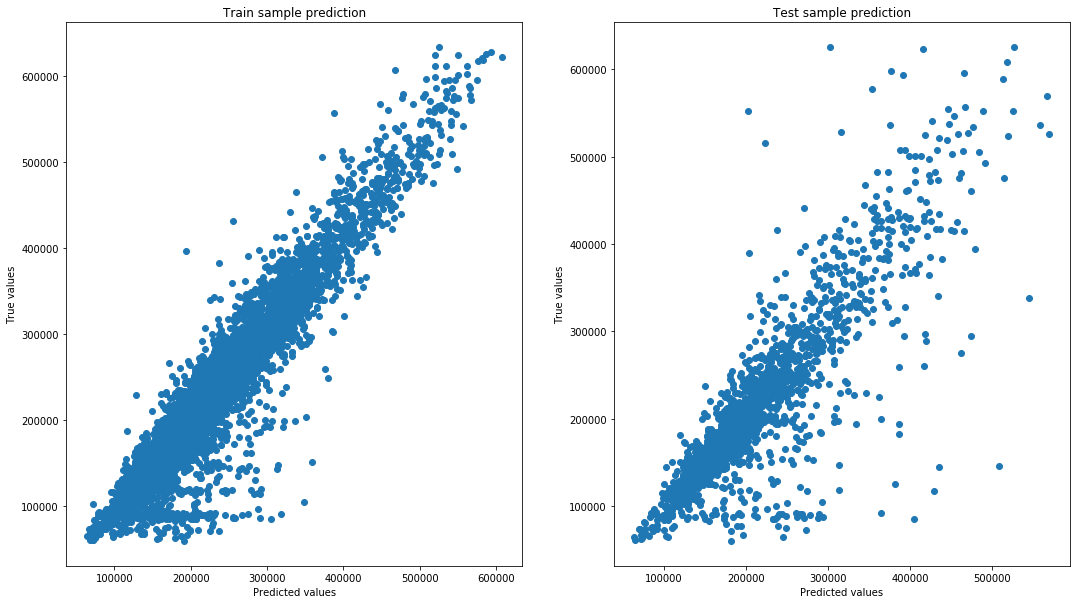

In [33]:
# fitting and saving model 
model.fit(X_train_prepared, y_train)
with open(MODEL_PATH, 'wb') as f:
    pickle.dump(model, f)
    
# predicting and evaluating
y_train_pred = model.predict(X_train_prepared)
y_test_pred = model.predict(X_test_prepared)
evaluate_preds(train_true_values = y_train, 
               train_pred_values = y_train_pred, 
               test_true_values = y_test,
               test_pred_values = y_test_pred)
# kinda overtrained( but lower depth is seems worse

In [34]:
# import of test dataset
df_final = pd.DataFrame(pd.read_csv(DATASET_TEST_PATH))
df_final.index = df_final["Id"]
df_final = df_final.drop("Id", axis = 1)

In [35]:
# preparing and predicting final predictions
X_final_prepared = dp.transform(df_final, can_delete_rows = False, reduce_mem = False)
y_final = pd.DataFrame(model.predict(X_final_prepared), index = X_final_prepared.index, columns = ["Price"])
y_final.to_csv(OUTPUT_PATH, sep = ",", header = True)